In [1]:
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
import pandas as pd
import calendar
import matplotlib as mpl
%matplotlib inline

In [2]:
from __future__ import division
import scipy.signal
import os
import nitime.algorithms as tsa
import os
from osgeo import gdal
import scipy.signal
#plt.style.use('ggplot')
import datetime
import sys
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

D:\Python27x64\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
print sys.version
print pd.__version__

2.7.6 (default, Nov 10 2013, 19:24:24) [MSC v.1500 64 bit (AMD64)]
0.17.1


In [4]:
# Topics: line, color, LineCollection, cmap, colorline, codex
'''
Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
The color is taken from optional data in z, and creates a LineCollection.

z can be:
- empty, in which case a default coloring will be used based on the position along the input arrays
- a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
- an array of the length of at least the same length as x, to color according to this data
- an array of a smaller length, in which case the colors are repeated along the curve

The function colorline returns the LineCollection created, which can be modified afterwards.

See also: plt.streamplot
'''

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

In [5]:
def listall(RootFolder, wildcard=''):
    lists = [os.path.join(root, name)    
                 for root, dirs, files in os.walk(RootFolder)
                   for name in files
                   if wildcard in name
                     if name.endswith('.tif')]
    return lists

In [6]:
def getDatums(files):
    """
    Get dates from list of files
    Typical date is "2010120" year + doy    
    """
    dates = []
    for filename in files:
        year = int(filename[-11:-7])
        days = int(filename[-7:-4])    
        dates.append(datetime.datetime(year, 1, 1) + datetime.timedelta(days - 1))
    return dates

In [7]:
def getDatumsLST(files):
    """
    Get dates from list of files
    Typical date is "20101012" year + month + day
    """
    dates = []
    for filename in files:
        year = int(filename[-12:-8])
        month = int(filename[-8:-6])
        days = int(filename[-6:-4])    
        dates.append(datetime.datetime(year, month, days))
    return dates

In [8]:
def getData(files, path_base, rowx, coly, xBlockSize, yBlockSize):
    """
    Input:
    files_ndvi = list_all(folder_ndvi)    
    path_base = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\InnerMongolia\NDVI\RAW2//NDVI_IM_2003001.tif'    
    
    rowx = 300
    coly = 700    
    
    #blockSizes = utils.GetBlockSize(band)
    xBlockSize = 5
    yBlockSize = 5         
    """

    print files[0], path_base, rowx, coly, xBlockSize, yBlockSize
    # register all of the GDAL drivers
    gdal.AllRegister()

    # open the image
    ds = gdal.Open(path_base, gdal.GA_ReadOnly)
    if ds is None:
        print 'Could not open base file'
        sys.exit(1)

    # get image size
    rows = ds.RasterYSize
    cols = ds.RasterXSize
    bands = ds.RasterCount

    # get the band and block sizes
    band = ds.GetRasterBand(1)
    base = band.ReadAsArray()
    nan = band.GetNoDataValue()

    # loop through the rows
    for i in range(0, rows, yBlockSize): # #(rowx-1, rowx, yBlockSize)
        if i + yBlockSize < rows:
            numRows = yBlockSize
        else:
            numRows = rows - i

        # loop through the columns
        for j in range(0, cols, xBlockSize):#  #(coly-1, coly, xBlockSize)
            if j + xBlockSize < cols:
                numCols = xBlockSize
            else:
                numCols = cols - j

            print j, i, numCols, numRows
            # set base array to fill 
            data_array = np.zeros(shape=(len(files),numRows,numCols), dtype=np.float32)

            # select blocks from trmm and ndvi files
            for m in range(len(files)):

                raster = gdal.Open(files[m], gdal.GA_ReadOnly)
                band = raster.GetRasterBand(1)            
                data_array[m] = band.ReadAsArray(j, i, numCols, numRows).astype(np.float)

            # reshape from 3D to 2D
            data_array = data_array.reshape((int(data_array.shape[0]), 
                                             int(data_array.shape[1]*data_array.shape[2]))).T
    return data_array

In [9]:
def getDataLST(files, path_base):
    """
    Input:
    folder_lst = r'D:\Downloads\Mattijn@Jia\LST_rasdaman'
    path_base = r'D:\Downloads\Mattijn@Jia\LST_rasdaman//LST_20111230.tif'    
    """
    
    print files[0], path_base
    # register all of the GDAL drivers
    gdal.AllRegister()

    # open the image
    ds = gdal.Open(path_base, gdal.GA_ReadOnly)
    if ds is None:
        print 'Could not open base file'
        sys.exit(1)

    # get image size
    rows = ds.RasterYSize
    cols = ds.RasterXSize
    bands = ds.RasterCount

    # get the band and block sizes
    band = ds.GetRasterBand(1)
    base = band.ReadAsArray()
    nan = band.GetNoDataValue()

    # set base array to fill 
    data_array = np.zeros(shape=(len(files),rows,cols), dtype=np.float32)

    for m in range(len(files)):
        print m

        raster = gdal.Open(files[m], gdal.GA_ReadOnly)
        band = raster.GetRasterBand(1)            
        data_array[m] = band.ReadAsArray().astype(np.float)

    # reshape from 3D to 2D
    data_array = data_array.reshape((int(data_array.shape[0]), 
                                     int(data_array.shape[1]*data_array.shape[2]))).T
    return data_array

In [10]:
def plot_average(df_avgmonth_allyears):
    NPOINTS = len(ysel_class['NDVI'])
    MAP='viridis' # choose carefully, or color transitions will not appear smoooth
    
    x = df_avgmonth_allyears['NDVI']
    y = df_avgmonth_allyears['CHIRP']
    z = df_avgmonth_allyears['LST']
    
    cm = plt.get_cmap(MAP)
    
    fig = plt.figure(figsize=(12,4))
    # --- # --- # --- # --- # --- # ax1 # --- # --- # --- # --- # --- #
    ax1 = plt.subplot(131)
    # data for single year
    ax1.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    for i in range(NPOINTS-1):
        ax1.plot(x[i:i+2],y[i:i+2],zorder=3)
    ax1.scatter(x,y,c=np.linspace(0,1,NPOINTS), s=40,zorder=4, cmap=cm)
    # data for mean
    #ax1.plot(a,b, color='gray')
    #ax1.scatter(a,b,c=np.linspace(0,1,NPOINTS), s=20)
    # axis settings
    ax1.xaxis.set_ticklabels(qtls_NDVI_lst)
    ax1.xaxis.set_label_text('NDVI 5-quantiles')
    ax1.set_xlim(0,5)
    ax1.yaxis.set_ticklabels(qtls_TRMM_lst)
    ax1.yaxis.set_label_text('CHIRP 5-quantiles (mm)')
    ax1.set_ylim(0,5)
    ax1.grid(True)
    ax1.set_title('NDVI vs CHIRP')
    
    # --- # --- # --- # --- # --- # ax2 # --- # --- # --- # --- # --- #
    ax2 = plt.subplot(132)
    # data for single year
    ax2.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    for i in range(NPOINTS-1):
        ax2.plot(x[i:i+2],z[i:i+2],zorder=3)
    ax2.scatter(x,z,c=np.linspace(0,1,NPOINTS), s=40,zorder=4, cmap=cm)
    # data for mean
    #ax2.plot(a,c, color='gray')
    #ax2.scatter(a,c,c=np.linspace(0,1,NPOINTS), s=20)
    # axis settings
    ax2.xaxis.set_ticklabels(qtls_NDVI_lst)
    ax2.xaxis.set_label_text('NDVI 5-quantiles')
    ax2.set_xlim(0,5)
    ax2.yaxis.set_ticklabels(qtls_LST_lst)
    ax2.yaxis.set_label_text('LST 5-quantiles (degrees)')
    ax2.set_ylim(0,5)
    ax2.grid(True)
    ax2.set_title('NDVI vs LST')
    
    # --- # --- # --- # --- # --- # ax3 # --- # --- # --- # --- # --- #
    ax3 = plt.subplot(133)
    # data for single year
    ax3.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    for i in range(NPOINTS-1):
        ax3.plot(y[i:i+2],z[i:i+2],zorder=3)
    ax3.scatter(y,z,c=np.linspace(0,1,NPOINTS), s=40,zorder=4, cmap=cm)
    # data for mean
    #ax3.plot(c,b, color='gray')
    #ax3.scatter(c,b,c=np.linspace(0,1,NPOINTS), s=20)
    # axis settings
    ax3.yaxis.set_ticklabels(qtls_LST_lst)
    ax3.yaxis.set_label_text('LST 5-quantiles (degrees)')
    ax3.set_ylim(0,5)
    ax3.xaxis.set_ticklabels(qtls_TRMM_lst)
    ax3.xaxis.set_label_text('CHIRP 5-quantiles')
    ax3.set_xlim(0,5)
    ax3.grid(True)
    ax3.set_title('LST vs CHIRP')
    
    # color bar horizontal
    ax4 = fig.add_axes([0.135,-0.02,0.803,0.023])
    cmap = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = mpl.colorbar.ColorbarBase(ax4, cmap=cm, ticks=np.linspace(0,1,NPOINTS), 
                                    norm=norm,
                                    orientation='horizontal')
    cb.ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])#'%d-%m-%Y'
    cb.ax.tick_params('both', length=5)
    
    ax2.text(-8.2,5.70,'AVERAGE',fontsize=17)
    
    plt.tight_layout()
    plt.savefig(r'D:\Downloads\Mattijn@Jia\png\trial_7//average_IM.png', dpi=200, bbox_inches='tight')

In [11]:
def plot_path_anomalies(ysel_class, df_avgmonth_allyears, year, df_allyears_anomalies):
    """
    plot for a single year the path in the quantiles and the differences between the 
    overall average
    input:
    ysel_class: is the df containing the classified yearly data
    df_avgmonth_allyears: is the df containting the long term monthly averages
    """
    
    NPOINTS = len(ysel_class['NDVI'])
    MAP='viridis' # choose carefully, or color transitions will not appear smoooth
    
    x = ysel_class['NDVI']
    y = ysel_class['CHIRP']
    z = ysel_class['LST']
    
    a = df_avgmonth_allyears['NDVI']
    b = df_avgmonth_allyears['CHIRP']
    c = df_avgmonth_allyears['LST']
    
    d = {'NDVI' : pd.Series(x.as_matrix() - a.as_matrix(), index=x.index),
         'CHIRP': pd.Series(y.as_matrix() - b.as_matrix(), index=y.index),
         'LST'  : pd.Series(z.as_matrix() - c.as_matrix(), index=z.index)}
    df_anomalies = pd.DataFrame(d)
    df_allyears_anomalies = df_allyears_anomalies.append(df_anomalies)    
    
    cm = plt.get_cmap(MAP)
    
    fig = plt.figure(figsize=(12,8))
    
    ax1 = plt.subplot(231)
    # data for single year
    ax1.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    for i in range(NPOINTS-1):
        ax1.plot(x[i:i+2],y[i:i+2],zorder=3)
    ax1.scatter(x,y,c=np.linspace(0,1,NPOINTS), s=40,zorder=4, cmap=cm)
    # data for mean
    #ax1.plot(a,b, color='gray')
    #ax1.scatter(a,b,c=np.linspace(0,1,NPOINTS), s=20)
    # axis settings
    ax1.xaxis.set_ticklabels(qtls_NDVI_lst)
    ax1.xaxis.set_label_text('NDVI 5-quantiles')
    ax1.set_xlim(0,5)
    ax1.yaxis.set_ticklabels(qtls_TRMM_lst)
    ax1.yaxis.set_label_text('CHIRP 5-quantiles (mm)')
    ax1.set_ylim(0,5)
    ax1.grid(True)
    ax1.set_title('NDVI vs CHIRP')
    
    # --- # --- # --- # --- # --- # ax2 # --- # --- # --- # --- # --- #
    ax2 = plt.subplot(232)
    # data for single year
    ax2.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    for i in range(NPOINTS-1):
        ax2.plot(x[i:i+2],z[i:i+2],zorder=3)
    ax2.scatter(x,z,c=np.linspace(0,1,NPOINTS), s=40,zorder=4, cmap=cm)
    # data for mean
    #ax2.plot(a,c, color='gray')
    #ax2.scatter(a,c,c=np.linspace(0,1,NPOINTS), s=20)
    # axis settings
    ax2.xaxis.set_ticklabels(qtls_NDVI_lst)
    ax2.xaxis.set_label_text('NDVI 5-quantiles')
    ax2.set_xlim(0,5)
    ax2.yaxis.set_ticklabels(qtls_LST_lst)
    ax2.yaxis.set_label_text('LST 5-quantiles (degrees)')
    ax2.set_ylim(0,5)
    ax2.grid(True)
    ax2.set_title('NDVI vs LST')
    
    # --- # --- # --- # --- # --- # ax3 # --- # --- # --- # --- # --- #
    ax3 = plt.subplot(233)
    # data for single year
    ax3.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    for i in range(NPOINTS-1):
        ax3.plot(y[i:i+2],z[i:i+2],zorder=3)
    ax3.scatter(y,z,c=np.linspace(0,1,NPOINTS), s=40,zorder=4, cmap=cm)
    # data for mean
    #ax3.plot(c,b, color='gray')
    #ax3.scatter(c,b,c=np.linspace(0,1,NPOINTS), s=20)
    # axis settings
    ax3.yaxis.set_ticklabels(qtls_LST_lst)
    ax3.yaxis.set_label_text('LST 5-quantiles (degrees)')
    ax3.set_ylim(0,5)
    ax3.xaxis.set_ticklabels(qtls_TRMM_lst)
    ax3.xaxis.set_label_text('CHIRP 5-quantiles')
    ax3.set_xlim(0,5)
    ax3.grid(True)
    ax3.set_title('LST vs CHIRP')
    
    # --- # --- # --- # --- # --- # ax4 # --- # --- # --- # --- # --- #
    ax1 = plt.subplot(234)
    # plot matrix
    ax1.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    for i in range(NPOINTS-1):
        ax1.plot((x.as_matrix() - a.as_matrix())[i:i+2],(y.as_matrix() - b.as_matrix())[i:i+2],zorder=3)
    ax1.scatter((x.as_matrix() - a.as_matrix()),(y.as_matrix() - b.as_matrix()),c=np.linspace(0,1,NPOINTS), 
                s=40,zorder=4, cmap=cm)
    # axes settings
    ax1.set_xlim(-1.1,1.1)
    ax1.set_ylim(-1.1,1.1)
    ax1.vlines(0,-1.1,1.1,zorder=2)
    ax1.hlines(0,-1.1,1.1,zorder=2)
    ax1.xaxis.set_ticks([-1,-0.5,0,0.5,1])
    ax1.yaxis.set_ticks([-1,-0.5,0,0.5,1])
    ax1.xaxis.set_ticklabels(['-20%','-10%', 'normal', '10%', '20%'])
    ax1.yaxis.set_ticklabels(['-20%','-10%', 'normal', '10%', '20%'])
    ax1.xaxis.set_label_text('NDVI')    
    ax1.yaxis.set_label_text('CHIRP')
    ax1.grid(True)
    ax1.set_title('NDVI vs CHIRP')
    
    # --- # --- # --- # --- # --- # ax5 # --- # --- # --- # --- # --- #
    ax2 = plt.subplot(235)
    # plot matrix
    ax2.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    for i in range(NPOINTS-1):
        ax2.plot((x.as_matrix() - a.as_matrix())[i:i+2],(z.as_matrix() - c.as_matrix())[i:i+2],zorder=3)
    ax2.scatter((x.as_matrix() - a.as_matrix()),(z.as_matrix() - c.as_matrix()),c=np.linspace(0,1,NPOINTS), 
                s=40,zorder=4, cmap=cm)
    # axes settings
    ax2.set_xlim(-1.1,1.1)
    ax2.set_ylim(-1.1,1.1)
    ax2.vlines(0,-1.1,1.1,zorder=2)
    ax2.hlines(0,-1.1,1.1,zorder=2)
    ax2.xaxis.set_ticks([-1,-0.5,0,0.5,1])
    ax2.yaxis.set_ticks([-1,-0.5,0,0.5,1])
    ax2.xaxis.set_ticklabels(['-20%','-10%', 'normal', '10%', '20%'])
    ax2.yaxis.set_ticklabels(['-20%','-10%', 'normal', '10%', '20%'])
    ax2.xaxis.set_label_text('NDVI')    
    ax2.yaxis.set_label_text('LST')
    ax2.grid(True)
    ax2.set_title('NDVI vs LST')
    
    # --- # --- # --- # --- # --- # ax6 # --- # --- # --- # --- # --- #
    ax3 = plt.subplot(236)
    # plot matrix
    ax3.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    for i in range(NPOINTS-1):
        ax3.plot((y.as_matrix() - b.as_matrix())[i:i+2],(z.as_matrix() - c.as_matrix())[i:i+2],zorder=3)
    ax3.scatter((y.as_matrix() - b.as_matrix()),(z.as_matrix() - c.as_matrix()),c=np.linspace(0,1,NPOINTS), 
                s=40,zorder=4, cmap=cm)
    # axes settings
    ax3.set_xlim(-1.1,1.1)
    ax3.set_ylim(-1.1,1.1)
    ax3.vlines(0,-1.1,1.1,zorder=2)
    ax3.hlines(0,-1.1,1.1,zorder=2)
    ax3.xaxis.set_ticks([-1,-0.5,0,0.5,1])
    ax3.yaxis.set_ticks([-1,-0.5,0,0.5,1])
    ax3.xaxis.set_ticklabels(['-20%','-10%', 'normal', '10%', '20%'])
    ax3.yaxis.set_ticklabels(['-20%','-10%', 'normal', '10%', '20%'])
    ax3.yaxis.set_label_text('LST')    
    ax3.xaxis.set_label_text('CHIRP')
    ax3.grid(True)
    ax3.set_title('LST vs CHIRP')
    
    ax4 = fig.add_axes([0.135,-0.02,0.803,0.018])
    cmap = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = mpl.colorbar.ColorbarBase(ax4, cmap=cm, ticks=np.linspace(0,1,NPOINTS), 
                                    norm=norm,
                                    orientation='horizontal')
    cb.ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])#'%d-%m-%Y'
    cb.ax.tick_params('both', length=5)
    
    ax2.text(-4.5,4.00,str(year),fontsize=17)
    plt.tight_layout()
    plt.savefig(r'D:\Downloads\Mattijn@Jia\png\trial_7\path_anomalies//'+str(year)+'path_anomalies_IM.png', dpi=200, bbox_inches='tight')
    plt.clf()

Compute the cubic

Get quantiles for NDVI

In [38]:
folder_ndvi = r'D:\Data\LS_DATA\ndvi-8day_IM_bbox_warp'
path_base_ndvi = r'D:\Data\LS_DATA\ndvi-8day_IM_bbox_warp//CN_2003_NDVI_recon.008_IM_bbox_wrap.tif'

# get files from list
files_ndvi = listall(folder_ndvi)

In [39]:
# using the parameters do the work
data_NDVI = getDataLST(files_ndvi, path_base_ndvi)

D:\Data\LS_DATA\ndvi-8day_IM_bbox_warp\CN_2000_NDVI_recon.008_IM_bbox_wrap.tif D:\Data\LS_DATA\ndvi-8day_IM_bbox_warp//CN_2003_NDVI_recon.008_IM_bbox_wrap.tif
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237

In [40]:
# mask NDVI where equal to NaN and create pandas time series
ds_ma = np.ma.masked_equal(data_NDVI, data_NDVI.min()) #-99999
ds_ma = np.ma.masked_equal(ds_ma, -3000) #-3000
ds_ma = ds_ma.compressed()/10000.

In [ ]:
qcut_ndvi = np.percentile(ds_ma,(10,20,30,40,50,60,70,80,90))

In [41]:
qcut_ndvi = np.array([0.1079, 0.1556, 0.1842, 0.2066, 0.2334, 0.2775, 0.34889999, 0.46720001, 0.6383]) # NEW

In [42]:
# Compute histogram as line plot
#y,binEdges=np.histogram(ds_ma.compressed()/10000., bins=100)
#bincenters = 0.5*(binEdges[1:]+binEdges[:-1])

# Compute the 5-quantiles using pandas quantile function
#qcut_ndvi = df.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
qtls_NDVI = qcut_ndvi.round(2)
qtls_NDVI_major = qcut_ndvi.take([1,3,5,7]).round(2)
qtls_NDVI_minor = qcut_ndvi.take([0,2,4,6,8]).round(2)

In [ ]:
#qtls_NDVI = np.array([0.1,0.16,0.18,0.21,0.23,0.27,0.35,0.47,0.65]) # OLD

In [ ]:
import random
ds_ma_sample = np.array(random.sample(ds_ma,1000))

In [ ]:
ds_ma_sample.m

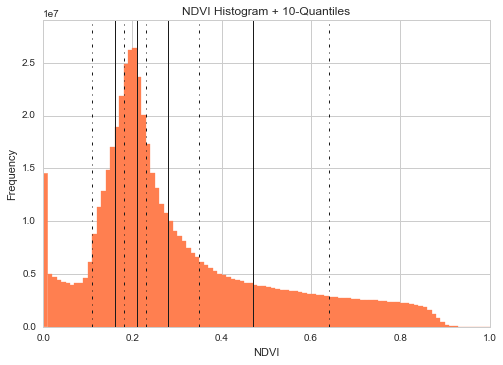

In [43]:
# Plot normal histogram and add quantiles as vlines
#plt.plot(bincenters,y,lw=1, color=plt.rcParams['axes.color_cycle'][5])
hist = plt.hist(ds_ma, bins=100, color='coral', edgecolor='coral')
hist_max = hist[0].max() + (hist[0].max()*0.1)
plt.vlines(qtls_NDVI_major,0,hist_max, lw=1,linestyle='solid',color='k')
plt.vlines(qtls_NDVI_minor,0,hist_max, lw=1,linestyle='dashdot',color='k')
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.ylim(0,hist_max)
#plt.suptitle('NDVI 5x5 time-series 2003-2012')
plt.title('NDVI Histogram + 10-Quantiles')

#plt.savefig(r'D:\Downloads\Mattijn@Jia\png/trial_2//Histogram_quantiles_NDVI.png', dpi=150)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(r'D:\Downloads\Mattijn@Jia\png/trial_7//Histogram_quantiles_NDVI.png', dpi=250)


In [25]:
ds_ma = None
df = None
plt.clf()

For TRMM 30-Day precipitation

In [26]:
folder_trmm = r'D:\Data\LS_DATA\chirps-prep_IM_bbox_warp'
path_base_trmm = r'D:\Data\LS_DATA\chirps-prep_IM_bbox_warp//chirps-v2.0.1981.01_IM_bbox_wrap.tif'

# get files from list
files_trmm = listall(folder_trmm)

In [27]:
# using the parameters do the work
data_TRMM = getDataLST(files_trmm, path_base_trmm)

D:\Data\LS_DATA\chirps-prep_IM_bbox_warp\chirps-v2.0.1981.01_IM_bbox_wrap.tif D:\Data\LS_DATA\chirps-prep_IM_bbox_warp//chirps-v2.0.1981.01_IM_bbox_wrap.tif
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
2

In [28]:
# mask CHIRPS where equal to NaN and create pandas time series
#ds_ma = np.ma.masked_equal(data_TRMM, data_TRMM.min()) #-99999
#ds_ma = np.ma.masked_equal(ds_ma, -9999) #-3000
#df = pd.Series(ds_ma.compressed())

ds_ma = np.ma.masked_equal(data_TRMM, data_TRMM.min()) #-99999
ds_ma = ds_ma.compressed()

In [29]:
#qcut_trmm = np.percentile(,(10,20,30,40,50,60,70,80,90))
qcut_trmm = np.array([  1.99279498,   3.17862291,   5.01596107,   7.95896397,
        13.34417582,  22.47401276,  36.94086227,  58.42534866,  94.39927063]) # NEW

In [30]:
# Compute histogram as line plot
#y,binEdges=np.histogram(ds_ma.compressed(),bins=100)
#bincenters = 0.5*(binEdges[1:]+binEdges[:-1])

# Compute the 5-quantiles using pandas quantile function
#qcut_trmm = df.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]) OLD
#qcut_trmm.as_matrix().round(2)
qtls_TRMM = qcut_trmm.round(2)
qtls_TRMM_major = qcut_trmm.take([1,3,5,7]).round(2)
qtls_TRMM_minor = qcut_trmm.take([0,2,4,6,8]).round(2)

In [31]:
#qtls_TRMM = np.array([1.99,3.18,5.02,7.96,13.34,22.47,36.94,58.43,94.4]) OLD

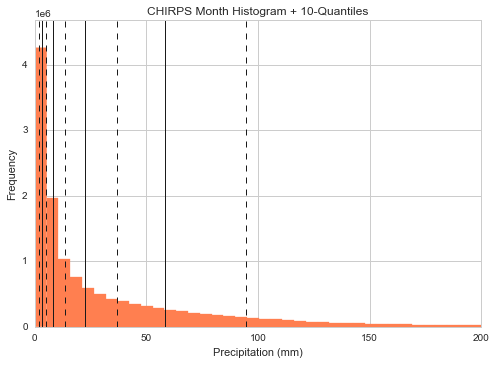

In [36]:
# Plot normal histogram and add quantiles as vlines
#plt.plot(bincenters,y,lw=1, color=plt.rcParams['axes.color_cycle'][5])
yfmt = mpl.ticker.ScalarFormatter()
yfmt.set_powerlimits((0,5))
hist = plt.hist(ds_ma, bins=100, color='coral', edgecolor='coral')
hist_max = hist[0].max() + (hist[0].max()*0.1)
plt.vlines(qtls_TRMM_major,0,hist_max, lw=1,linestyle='solid',color='k')
plt.vlines(qtls_TRMM_minor,0,hist_max, lw=1,linestyle='dashed',color='k')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Frequency')
plt.ylim(0,hist_max)
plt.xlim(0,200)
#plt.suptitle('NDVI 5x5 time-series 2003-2012')
plt.title('CHIRPS Month Histogram + 10-Quantiles')
plt.gca().yaxis.set_major_formatter(yfmt)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(r'D:\Downloads\Mattijn@Jia\png/trial_7//Histogram_quantiles_CHIRPS1m.png', dpi=250)

In [37]:
ds_ma = None
df = None
plt.clf()

For LST precipitation

In [13]:
folder_lst = r'D:\Data\LS_DATA\LST-8day_IM_bbox_warp'
path_base_lst = r'D:\Data\LS_DATA\LST-8day_IM_bbox_warp//CN_2003_LST_recon.008_IM_bbox_wrap.tif'

# get files from list
files_lst = listall(folder_lst)

In [14]:
# using the parameters do the work
data_LST = getDataLST(files_lst, path_base_lst)

D:\Data\LS_DATA\LST-8day_IM_bbox_warp\CN_2000_LST_recon.008_IM_bbox_wrap.tif D:\Data\LS_DATA\LST-8day_IM_bbox_warp//CN_2003_LST_recon.008_IM_bbox_wrap.tif
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238

In [15]:
# mask LST where equal to NaN and create pandas time series
ds_ma = np.ma.masked_equal(data_LST, data_LST.min()) #-9999
ds_ma = np.ma.masked_equal(ds_ma, 0) #-9999
ds_ma = np.ma.masked_equal(ds_ma, 11000) #-9999
ds_ma = ds_ma.compressed()/1000.

In [18]:
#qcut_lst = np.percentile(ds_ma,(10,20,30,40,50,60,70,80,90))
qcut_lst = np.array([ 13.20100021,  13.60000038,  13.95600033,  14.33699989,
                  14.66100025,  14.88500023,  15.05500031,  15.22999954,  15.43700027])
qcut_lst

array([ 13.20100021,  13.60000038,  13.95600033,  14.33699989,
        14.66100025,  14.88500023,  15.05500031,  15.22999954,  15.43700027])

In [19]:
# Compute histogram as line plot
#y,binEdges=np.histogram(ds_ma.compressed()/1000,bins=100)
#bincenters = 0.5*(binEdges[1:]+binEdges[:-1])

# Compute the 5-quantiles using pandas quantile function
#qcut_lst = df.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
#qcut_lst.as_matrix().round(2)
qtls_LST = qcut_lst.round(2)
qtls_LST_major = qcut_lst.take([1,3,5,7]).round(2)
qtls_LST_minor = qcut_lst.take([0,2,4,6,8]).round(2)

In [20]:
#qtls_LST = np.array([13.19,13.59,13.94,14.33,14.66,14.88,15.04,15.21,15.42]) # OLD

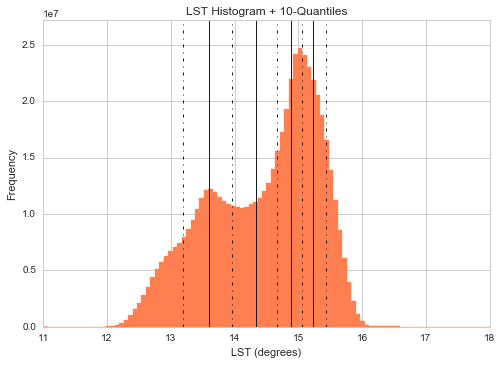

In [24]:
# Plot normal histogram and add quantiles as vlines
#plt.plot(bincenters,y,lw=1, color=plt.rcParams['axes.color_cycle'][5])
hist = plt.hist(ds_ma, bins=100,color='coral', edgecolor='coral')
hist_max = hist[0].max() + (hist[0].max()*0.1)
plt.vlines(qtls_LST_major,0,hist_max, lw=1,linestyle='solid',color='k')
plt.vlines(qtls_LST_minor,0,hist_max, lw=1,linestyle='dashdot',color='k')
plt.xlabel('LST (degrees)')
plt.ylabel('Frequency')
plt.ylim(0,hist_max)
#plt.suptitle('NDVI 5x5 time-series 2003-2012')
plt.title('LST Histogram + 10-Quantiles')

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(r'D:\Downloads\Mattijn@Jia\png\trial_7//Histogram_quantiles_LST.png', dpi=150)

In [44]:
ds_ma = None
df = None
plt.clf()

Get 2009 data

In [ ]:
# files_ndvi_sel = files_ndvi[270:315] #2009
# files_ndvi_sel[0:2]

In [ ]:
# # NDVI
# files_ndvi_sel = files_ndvi[270:315] # 2009
# #files_ndvi_sel = files_ndvi[225:270] # 2008
# dates_ndvi_sel = []
# for filename in files_ndvi_sel:
#     year = int(filename[-36:-32])
#     days = int(filename[-20:-17])    
#     dates_ndvi_sel.append(datetime.datetime(year, 1, 1) + datetime.timedelta(days - 1))

# # extract data
# data_NDVI_sel = getDataLST(files_ndvi_sel, path_base_ndvi)

# # mask NDVI where equal to NaN and create pandas time series
# ds_ma = np.ma.masked_equal(data_NDVI_sel, data_NDVI_sel.min()) #-99999
# ds_ma = np.ma.masked_equal(ds_ma, -3000) #-3000
# ds_avg = np.ma.mean(ds_ma, axis = 0)

# avg_ndvi_sel = pd.Series(ds_avg.compressed()/10000.)

# # create pandas series of the mean and observations
# ysel_ndvi = pd.DataFrame({'NDVI':avg_ndvi_sel, 'date':np.asarray(dates_ndvi_sel)})
# ysel_ndvi.set_index('date', inplace=True)

In [ ]:
# # LST
# files_lst_sel = files_lst[270:315] # 2009 
# #files_lst_sel = files_lst[225:270] # 2008
# dates_lst_sel = []
# for filename in files_lst_sel:
#     year = int(filename[-35:-31])
#     days = int(filename[-20:-17])
#     dates_lst_sel.append(datetime.datetime(year, 1, 1) + datetime.timedelta(days - 1))

# # using the parameters do the work
# data_LST_sel = getDataLST(files_lst_sel, path_base_lst)

# # mask NDVI where equal to NaN and create pandas time series
# ds_ma = np.ma.masked_equal(data_LST_sel, data_LST_sel.min()) #-99999
# ds_ma = np.ma.masked_equal(ds_ma, 0) #-9999
# ds_ma = np.ma.masked_equal(ds_ma, 11000) #-9999
# ds_avg = np.ma.mean(ds_ma, axis = 0)

# avg_lst_sel = pd.Series(ds_avg.compressed()/1000.)

# # create pandas series of the mean and observations
# ysel_lst = pd.DataFrame({'LST':avg_lst_sel, 'date':np.asarray(dates_lst_sel)})
# ysel_lst.set_index('date', inplace=True)

In [ ]:
# # CHIRP
# files_trmm_sel = files_trmm[336:348] # 2009
# #files_trmm_sel = files_trmm[324:336] # 2008
# dates_trmm_sel = []
# for filename in files_trmm_sel:
#     year = int(filename[-24:-20])
#     month = int(filename[-19:-17])    
#     end_day_month = calendar.monthrange(year,month)[1]
#     dates_trmm_sel.append(datetime.datetime(year, month, end_day_month))

# # extract data
# data_TRMM_sel = getDataLST(files_trmm_sel, path_base_trmm)

# # mask CHIRPS where equal to NaN and create pandas time series
# ds_ma = np.ma.masked_equal(data_TRMM_sel, -9999.)
# #ds_ma = np.ma.masked_equal(ds_ma, -9999) #-3000
# ds_avg = np.ma.mean(ds_ma, axis = 0)

# avg_trmm_sel = pd.Series(ds_avg.compressed())

# # create pandas series of the mean and observations
# ysel_trmm = pd.DataFrame({'CHIRP':avg_trmm_sel, 'date':np.asarray(dates_trmm_sel)})
# ysel_trmm.set_index('date', inplace=True)

In [45]:
qtls_NDVI_lst = qtls_NDVI.tolist()
qtls_NDVI_lst.insert(0,' ')
qtls_NDVI_lst.append(' ')

qtls_TRMM_lst = qtls_TRMM.tolist()
qtls_TRMM_lst.insert(0,' ')
qtls_TRMM_lst.append(' ')  

qtls_LST_lst = qtls_LST.tolist()
qtls_LST_lst.insert(0,' ')
qtls_LST_lst.append(' ')

In [46]:
# # concatenate all dimensions and resmaple to decads
# ysel_comb = pd.concat([ysel_ndvi,ysel_trmm,ysel_lst],axis=1)
# ysel_comb = ysel_comb.resample("M", how='mean')
# #ysel_comb.to_excel(r'D:\Downloads\Mattijn@Jia\data//comb_sel_ndvi_trmm_lst_monthly.xlsx')

In [47]:
# ysel_comb

In [48]:
print 'ndvi', qtls_NDVI, '\n'
print 'lst', qtls_LST, '\n'
print 'trmm', qtls_TRMM,'\n'

ndvi [ 0.11  0.16  0.18  0.21  0.23  0.28  0.35  0.47  0.64] 

lst [ 13.2   13.6   13.96  14.34  14.66  14.89  15.06  15.23  15.44] 

trmm [  1.99   3.18   5.02   7.96  13.34  22.47  36.94  58.43  94.4 ] 



In [ ]:
# # do a deep copy and classify the variables
# ysel_class = None
# ysel_class = df_allyears_raw.copy()

In [ ]:
# ysel_class['NDVI'].loc[(ysel_class['NDVI'] <= qtls_NDVI[0])] = 0.25

In [ ]:
# if len(ysel_class.loc[(ysel_class['NDVI'] >= round(qtls_NDVI[8],2)), 'NDVI']) != 0:
#     ysel_class.loc[(ysel_class['NDVI'] >= round(qtls_NDVI[8],2)), 'NDVI'] = 4.75

In [ ]:
# # NDVI
# if len(ysel_class.loc[(ysel_class['NDVI'] <= round(qtls_NDVI[0],2)), 'NDVI']) != len(ysel_class):
#     if len(ysel_class.loc[(ysel_class['NDVI'] <= round(qtls_NDVI[0],2)), 'NDVI']) != 0:
#         print ysel_class.loc[(ysel_class['NDVI'] <= round(qtls_NDVI[0],2)), 'NDVI']
#         ysel_class.loc[(ysel_class['NDVI'] <= round(qtls_NDVI[0],2)), 'NDVI'] = 0.25
# ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[0],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[1],2)), 'NDVI'] = 0.75
# ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[1],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[2],2)), 'NDVI'] = 1.25
# ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[2],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[3],2)), 'NDVI'] = 1.75
# ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[3],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[4],2)), 'NDVI'] = 2.25
# ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[4],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[5],2)), 'NDVI'] = 2.75
# ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[5],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[6],2)), 'NDVI'] = 3.25
# ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[6],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[7],2)), 'NDVI'] = 3.75
# ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[7],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[8],2)), 'NDVI'] = 4.25
# if len(ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[8],2)), 'NDVI']) != len(ysel_class):
#     if len(ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[8],2)), 'NDVI']) != 0:
#         print ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[8],2)), 'NDVI']
#         ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[8],2)), 'NDVI'] = 4.75

# # CHIRP    
# if len(ysel_class.loc[(ysel_class['CHIRP'] <= round(qtls_TRMM[0],2)), 'CHIRP']) != len(ysel_class):    
#     if len(ysel_class.loc[(ysel_class['CHIRP'] <= round(qtls_TRMM[0],2)), 'CHIRP']) != 0:
#         print ysel_class.loc[(ysel_class['CHIRP'] <= round(qtls_TRMM[0],2)), 'CHIRP']
#         ysel_class.loc[(ysel_class['CHIRP'] <= round(qtls_TRMM[0],2)), 'CHIRP'] = 0.25
# ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[0],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[1],2)), 'CHIRP'] = 0.75
# ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[1],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[2],2)), 'CHIRP'] = 1.25
# ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[2],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[3],2)), 'CHIRP'] = 1.75
# ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[3],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[4],2)), 'CHIRP'] = 2.25
# ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[4],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[5],2)), 'CHIRP'] = 2.75
# ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[5],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[6],2)), 'CHIRP'] = 3.25
# ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[6],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[7],2)), 'CHIRP'] = 3.75
# ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[7],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[8],2)), 'CHIRP'] = 4.25
# if len(ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[8],2)), 'CHIRP']) != len(ysel_class):
#     if len(ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[8],2)), 'CHIRP']) != 0:
#         print ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[8],2)), 'CHIRP']
#         ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[8],2)), 'CHIRP'] = 4.75

# # LST    
# if len(ysel_class.loc[(ysel_class['LST'] <= round(qtls_LST[0],2)), 'LST']) != len(ysel_class):    
#     if len(ysel_class.loc[(ysel_class['LST'] <= round(qtls_LST[0],2)), 'LST']) != 0:
#         print ysel_class.loc[(ysel_class['LST'] <= round(qtls_LST[0],2)), 'LST']
#         ysel_class.loc[(ysel_class['LST'] <= round(qtls_LST[0],2)), 'LST'] = 0.25
# ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[0],2)) & (ysel_class['LST'] <= round(qtls_LST[1],2)), 'LST'] = 0.75
# ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[1],2)) & (ysel_class['LST'] <= round(qtls_LST[2],2)), 'LST'] = 1.25
# ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[2],2)) & (ysel_class['LST'] <= round(qtls_LST[3],2)), 'LST'] = 1.75
# ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[3],2)) & (ysel_class['LST'] <= round(qtls_LST[4],2)), 'LST'] = 2.25
# ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[4],2)) & (ysel_class['LST'] <= round(qtls_LST[5],2)), 'LST'] = 2.75
# ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[5],2)) & (ysel_class['LST'] <= round(qtls_LST[6],2)), 'LST'] = 3.25
# ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[6],2)) & (ysel_class['LST'] <= round(qtls_LST[7],2)), 'LST'] = 3.75
# ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[7],2)) & (ysel_class['LST'] <= round(qtls_LST[8],2)), 'LST'] = 4.25
# if len(ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[8],2)), 'LST']) != len(ysel_class):
#     if len(ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[8],2)), 'LST']) != 0:
#         print ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[8],2)), 'LST']
#         ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[8],2)), 'LST'] = 4.75    

In [ ]:
# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.pyplot as plt
# from matplotlib import cm

3d plot

In [ ]:
# for ii in np.linspace(0,359,360):
#     #CONSTANTS
#     NPOINTS = len(ysel_class['NDVI'])
#     COLOR='blue'
#     #RESFACT=10
#     MAP='jet' # choose carefully, or color transitions will not appear smoooth

#     # create random data    
#     x = ysel_class['NDVI']
#     y = ysel_class['CHIRP']
#     z = ysel_class['LST']

#     %matplotlib inline
#     fig = plt.figure(figsize=(8,8))
#     ax = plt.axes(projection='3d')

#     cm = plt.get_cmap(MAP)
#     ax.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
#     for i in range(NPOINTS-1):
#         ax.plot(x[i:i+2],y[i:i+2],z[i:i+2])
#         #ax.hold()
#         #ax.scatter(x[i:i+2],y[i:i+2],z[i:i+2])

#     #ax.plot(x,y,z)
#     ax.scatter(x,y,z,c=np.linspace(0,1,NPOINTS), s=40)


#     #ax.text(.05,1.05,'Reg. Res - Color Map')
#     ax.set_xlim(0,5)
#     ax.set_ylim(0,5)
#     ax.set_zlim(0,5)

#     qtls_NDVI_lst = qtls_NDVI.tolist()
#     qtls_NDVI_lst.insert(0,' ')
#     qtls_NDVI_lst.append(' ')

#     ax.w_xaxis.set_ticklabels(qtls_NDVI_lst)
#     ax.w_xaxis.set_label_text('NDVI 5-quantiles')

#     qtls_TRMM_lst = qtls_TRMM.tolist()
#     qtls_TRMM_lst.insert(0,' ')
#     qtls_TRMM_lst.append(' ')

#     ax.w_yaxis.set_ticklabels(qtls_TRMM_lst)
#     ax.w_yaxis.set_label_text('CHIRP 5-quantiles (mm)')
    
#     qtls_LST_lst = qtls_LST.tolist()
#     qtls_LST_lst.insert(0,' ')
#     qtls_LST_lst.append(' ')

#     ax.w_zaxis.set_ticklabels(qtls_LST_lst)
#     ax.w_zaxis.set_label_text('LST 5-quantiles (degrees)')

#     ax.azim=int(ii)#ii
#     ax.elev=20#ii

#     ax1 = fig.add_axes([0.93,0.25,0.03,0.50])
#     ax1.text(-2.2,-.20,'azim: '+str(ax.azim).zfill(3)+' elev: '+str(ax.elev).zfill(3))
#     ax1.text(-17.2,1.2,str(year)+' Inner Mongolia', fontsize=16)
#     cmap = mpl.cm.jet
#     norm = mpl.colors.Normalize(vmin=0, vmax=NPOINTS)

#     cb = mpl.colorbar.ColorbarBase(ax1, cmap=cm,
#                                     norm=norm,
#                                     orientation='vertical')
#     #cb.set_label('Some Units')
#     cb.ax.set_yticklabels(ysel_class.index.map(lambda x: x.strftime('%m-%Y')))
#     plt.savefig(r'D:\Downloads\Mattijn@Jia\png\trial_3\gif_'+str(year)+'//'+str(year)+'_'+
#                 str(int(ii))+'.png', dpi=100, bbox_inches='tight')
#     #plt.show    
#     plt.tight_layout
#     plt.clf()

In [ ]:
# df_allyears_raw

In [ ]:
# df_allyears_raw['CHIRP'].loc[df_allyears_raw['CHIRP'] > qtls_TRMM[8]]

In [ ]:
# #def plot_average(df_avgmonth_allyears):
# NPOINTS = len(ysel_class['NDVI'])
# MAP='jet' # choose carefully, or color transitions will not appear smoooth

# x = ysel_class['NDVI']
# y = ysel_class['CHIRP']
# z = ysel_class['LST']

# cm = plt.get_cmap(MAP)

# fig = plt.figure(figsize=(9,3))
# # --- # --- # --- # --- # --- # ax1 # --- # --- # --- # --- # --- #
# ax1 = plt.subplot(131)
# # data for single year
# ax1.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
# for i in range(NPOINTS-1):
#     ax1.plot(x[i:i+2],y[i:i+2],zorder=3)
# ax1.scatter(x,y,c=np.linspace(0,1,NPOINTS), s=40,zorder=4)
# # data for mean
# #ax1.plot(a,b, color='gray')
# #ax1.scatter(a,b,c=np.linspace(0,1,NPOINTS), s=20)
# # axis settings
# ax1.xaxis.set_ticklabels(qtls_NDVI_lst)
# ax1.xaxis.set_label_text('NDVI 5-quantiles')
# ax1.set_xlim(0,5)
# ax1.yaxis.set_ticklabels(qtls_TRMM_lst)
# ax1.yaxis.set_label_text('CHIRP 5-quantiles (mm)')
# ax1.set_ylim(0,5)
# ax1.grid(True)
# ax1.set_title('NDVI vs CHIRP')

# # --- # --- # --- # --- # --- # ax2 # --- # --- # --- # --- # --- #
# ax2 = plt.subplot(132)
# # data for single year
# ax2.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
# for i in range(NPOINTS-1):
#     ax2.plot(x[i:i+2],z[i:i+2],zorder=3)
# ax2.scatter(x,z,c=np.linspace(0,1,NPOINTS), s=40,zorder=4)
# # data for mean
# #ax2.plot(a,c, color='gray')
# #ax2.scatter(a,c,c=np.linspace(0,1,NPOINTS), s=20)
# # axis settings
# ax2.xaxis.set_ticklabels(qtls_NDVI_lst)
# ax2.xaxis.set_label_text('NDVI 5-quantiles')
# ax2.set_xlim(0,5)
# ax2.yaxis.set_ticklabels(qtls_LST_lst)
# ax2.yaxis.set_label_text('LST 5-quantiles (degrees)')
# ax2.set_ylim(0,5)
# ax2.grid(True)
# ax2.set_title('NDVI vs LST')

# # --- # --- # --- # --- # --- # ax3 # --- # --- # --- # --- # --- #
# ax3 = plt.subplot(133)
# # data for single year
# ax3.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
# for i in range(NPOINTS-1):
#     ax3.plot(z[i:i+2],y[i:i+2],zorder=3)
# ax3.scatter(z,y,c=np.linspace(0,1,NPOINTS), s=40,zorder=4)
# # data for mean
# #ax3.plot(c,b, color='gray')
# #ax3.scatter(c,b,c=np.linspace(0,1,NPOINTS), s=20)
# # axis settings
# ax3.xaxis.set_ticklabels(qtls_LST_lst)
# ax3.xaxis.set_label_text('LST 5-quantiles (degrees)')
# ax3.set_xlim(0,5)
# ax3.yaxis.set_ticklabels(qtls_TRMM_lst)
# ax3.yaxis.set_label_text('CHIRP 5-quantiles')
# ax3.set_ylim(0,5)
# ax3.grid(True)
# ax3.set_title('LST vs CHIRP')

# # color bar horizontal
# ax4 = fig.add_axes([0.135,-0.02,0.803,0.023])
# cmap = mpl.cm.jet
# norm = mpl.colors.Normalize(vmin=0, vmax=1)
# cb = mpl.colorbar.ColorbarBase(ax4, cmap=cm, ticks=np.linspace(0,1,NPOINTS), 
#                                 norm=norm,
#                                 orientation='horizontal')
# cb.ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])#'%d-%m-%Y'
# cb.ax.tick_params('both', length=5)

# ax2.text(-8.2,5.70,'AVERAGE',fontsize=17)

# plt.tight_layout()
# #plt.savefig(r'D:\Downloads\Mattijn@Jia\png\trial_3//average_IM.png', dpi=200, bbox_inches='tight')

In [ ]:
# ysel_class = pd.DataFrame()
# ysel_class

Do it for all years!

D:\Data\LS_DATA\ndvi-8day_IM_bbox_warp\CN_2000_NDVI_recon.008_IM_bbox_wrap.tif D:\Data\LS_DATA\ndvi-8day_IM_bbox_warp//CN_2003_NDVI_recon.008_IM_bbox_wrap.tif
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
D:\Data\LS_DATA\LST-8day_IM_bbox_warp\CN_2000_LST_recon.008_IM_bbox_wrap.tif D:\Data\LS_DATA\LST-8day_IM_bbox_warp//CN_2003_LST_recon.008_IM_bbox_wrap.tif
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
D:\Data\LS_DATA\chirps-prep_IM_bbox_warp\chirps-v2.0.2000.01_IM_bbox_wrap.tif D:\Data\LS_DATA\chirps-prep_IM_bbox_warp//chirps-v2.0.1981.01_IM_bbox_wrap.tif
0
1
2
3
4
5
6
7
8
9
10
11
date
2000-01-31    0.08894
Freq: M, Name: NDVI, dtype: float64
date
2000-01-31    13.080662
2000-12-31    13.140801
Freq: 11M, Name: LST, dtype: float64
date
2000-06-30    15.526511
2000-07-31    15.444258
Freq: M, Name: LST, dtype: float64
D:\Data\LS_D

D:\Python27x64\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\Python27x64\lib\site-packages\matplotlib\figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "



2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015


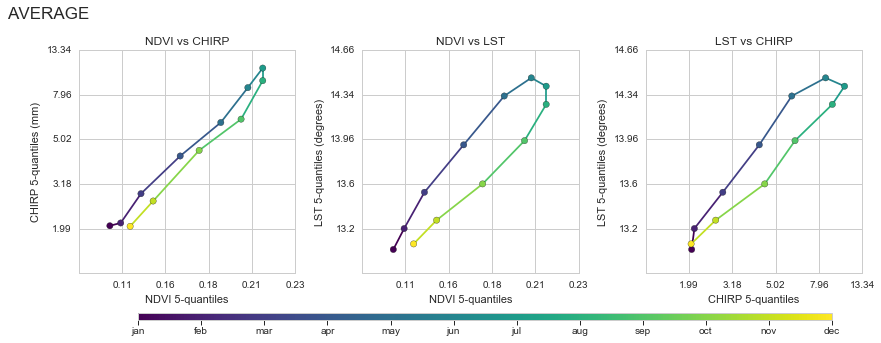

In [49]:
df_allyears_raw = pd.DataFrame()
df_allyears_class = pd.DataFrame()
df_allyears_anomalies = pd.DataFrame()
#df_allyears_anomalies 

for year in xrange(2000,2016,1):    
    # --- # --- # --- # --- # --- # --- # --- # --- # --- # --- # --- # --- 
    # 1. NDVI SELECTION
    # get selection files for ndvi
    files_ndvi_sel = []
    for ix, _file in enumerate(files_ndvi):    
        if str(year) in _file:
            files_ndvi_sel.append(files_ndvi[ix])

    dates_ndvi_sel = []
    for filename in files_ndvi_sel:
        year = int(filename[-36:-32])
        days = int(filename[-20:-17])    
        dates_ndvi_sel.append(datetime.datetime(year, 1, 1) + datetime.timedelta(days - 1))
    
    # extract data
    data_NDVI_sel = getDataLST(files_ndvi_sel, path_base_ndvi)
    
    # mask NDVI where equal to NaN and create pandas time series
    ds_ma = np.ma.masked_equal(data_NDVI_sel, data_NDVI_sel.min()) #-99999
    ds_ma = np.ma.masked_equal(ds_ma, -3000) #-3000
    ds_avg = np.ma.mean(ds_ma, axis = 0)
    
    avg_ndvi_sel = pd.Series(ds_avg.compressed()/10000.)
    
    # create pandas series of the mean and observations
    ysel_ndvi = pd.DataFrame({'NDVI':avg_ndvi_sel, 'date':np.asarray(dates_ndvi_sel)})
    ysel_ndvi.set_index('date', inplace=True)

    # --- # --- # --- # --- # --- # --- # --- # --- # --- # --- # --- # ---     
    # 2. LST SELECTION
    # get selection files for lst
    files_lst_sel = []
    for ix, _file in enumerate(files_lst):
        if str(year) in _file:
            files_lst_sel.append(files_lst[ix])

    dates_lst_sel = []
    for filename in files_lst_sel:
        year = int(filename[-35:-31])
        days = int(filename[-20:-17])
        dates_lst_sel.append(datetime.datetime(year, 1, 1) + datetime.timedelta(days - 1))
    
    # using the parameters do the work
    data_LST_sel = getDataLST(files_lst_sel, path_base_lst)
    
    # mask NDVI where equal to NaN and create pandas time series
    ds_ma = np.ma.masked_equal(data_LST_sel, data_LST_sel.min()) #-99999
    ds_ma = np.ma.masked_equal(ds_ma, 0) #-9999
    ds_ma = np.ma.masked_equal(ds_ma, 11000) #-9999
    ds_avg = np.ma.mean(ds_ma, axis = 0)
    
    avg_lst_sel = pd.Series(ds_avg.compressed()/1000.)
    
    # create pandas series of the mean and observations
    ysel_lst = pd.DataFrame({'LST':avg_lst_sel, 'date':np.asarray(dates_lst_sel)})
    ysel_lst.set_index('date', inplace=True)

    # --- # --- # --- # --- # --- # --- # --- # --- # --- # --- # --- # ---     
    # 3. PRECIPITATION SELECTION
    # get selection files for precipitation
    files_trmm_sel = []
    for ix, _file in enumerate(files_trmm):    
        if str(year) in _file:
            files_trmm_sel.append(files_trmm[ix])

    dates_trmm_sel = []
    for filename in files_trmm_sel:
        year = int(filename[-24:-20])
        month = int(filename[-19:-17])    
        end_day_month = calendar.monthrange(year,month)[1]
        dates_trmm_sel.append(datetime.datetime(year, month, end_day_month))
    
    # extract data
    data_TRMM_sel = getDataLST(files_trmm_sel, path_base_trmm)
    
    # mask CHIRPS where equal to NaN and create pandas time series
    ds_ma = np.ma.masked_equal(data_TRMM_sel, -9999.)
    #ds_ma = np.ma.masked_equal(ds_ma, -9999) #-3000
    ds_avg = np.ma.mean(ds_ma, axis = 0)
    
    avg_trmm_sel = pd.Series(ds_avg.compressed())
    
    # create pandas series of the mean and observations
    ysel_trmm = pd.DataFrame({'CHIRP':avg_trmm_sel, 'date':np.asarray(dates_trmm_sel)})
    ysel_trmm.set_index('date', inplace=True)

    # --- # --- # --- # --- # --- # --- # --- # --- # --- # --- # --- # ---     
    # 4. COMBINE AND CLASSIFY
    # concatenate all dimensions and resmaple to monthly interval
    ysel_comb = None
    ysel_comb = pd.concat([ysel_ndvi,ysel_trmm,ysel_lst],axis=1)
    ysel_comb = ysel_comb.resample("M", how='mean')    

    #print qcut_ndvi.as_matrix().round(2), qcut_lst.as_matrix().round(2), qcut_trmm.as_matrix().round(2)
    
    # do a deep copy and classify the variables
    ysel_class = None
    ysel_class = ysel_comb.copy()
    
    # NDVI

    ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[0],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[1],2)), 'NDVI'] = 0.75
    ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[1],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[2],2)), 'NDVI'] = 1.25
    ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[2],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[3],2)), 'NDVI'] = 1.75
    ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[3],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[4],2)), 'NDVI'] = 2.25
    ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[4],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[5],2)), 'NDVI'] = 2.75
    ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[5],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[6],2)), 'NDVI'] = 3.25
    ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[6],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[7],2)), 'NDVI'] = 3.75
    ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[7],2)) & (ysel_class['NDVI'] <= round(qtls_NDVI[8],2)), 'NDVI'] = 4.25
    if len(ysel_class.loc[(ysel_class['NDVI'] <= round(qtls_NDVI[0],2)), 'NDVI']) != len(ysel_class):
        if len(ysel_class.loc[(ysel_class['NDVI'] <= round(qtls_NDVI[0],2)), 'NDVI']) != 0:
            print ysel_class.loc[(ysel_class['NDVI'] <= round(qtls_NDVI[0],2)), 'NDVI']
            ysel_class.loc[(ysel_class['NDVI'] <= round(qtls_NDVI[0],2)), 'NDVI'] = 0.25
#    if len(ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[8],2)), 'NDVI']) != len(ysel_class):
#        if len(ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[8],2)), 'NDVI']) != 0:
#            print ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[8],2)), 'NDVI']
#            ysel_class.loc[(ysel_class['NDVI'] > round(qtls_NDVI[8],2)), 'NDVI'] = 4.75
    
    # CHIRP    
    if len(ysel_class.loc[(ysel_class['CHIRP'] <= round(qtls_TRMM[0],2)), 'CHIRP']) != len(ysel_class):    
        if len(ysel_class.loc[(ysel_class['CHIRP'] <= round(qtls_TRMM[0],2)), 'CHIRP']) != 0:
            print ysel_class.loc[(ysel_class['CHIRP'] <= round(qtls_TRMM[0],2)), 'CHIRP']
            ysel_class.loc[(ysel_class['CHIRP'] <= round(qtls_TRMM[0],2)), 'CHIRP'] = 0.25
    ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[0],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[1],2)), 'CHIRP'] = 0.75
    ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[1],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[2],2)), 'CHIRP'] = 1.25
    ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[2],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[3],2)), 'CHIRP'] = 1.75
    ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[3],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[4],2)), 'CHIRP'] = 2.25
    ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[4],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[5],2)), 'CHIRP'] = 2.75
    ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[5],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[6],2)), 'CHIRP'] = 3.25
    ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[6],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[7],2)), 'CHIRP'] = 3.75
    ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[7],2)) & (ysel_class['CHIRP'] <= round(qtls_TRMM[8],2)), 'CHIRP'] = 4.25
    if len(ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[8],2)), 'CHIRP']) != len(ysel_class):
        if len(ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[8],2)), 'CHIRP']) != 0:
            print ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[8],2)), 'CHIRP']
            ysel_class.loc[(ysel_class['CHIRP'] > round(qtls_TRMM[8],2)), 'CHIRP'] = 4.75
    
    # LST    
    if len(ysel_class.loc[(ysel_class['LST'] <= round(qtls_LST[0],2)), 'LST']) != len(ysel_class):    
        if len(ysel_class.loc[(ysel_class['LST'] <= round(qtls_LST[0],2)), 'LST']) != 0:
            print ysel_class.loc[(ysel_class['LST'] <= round(qtls_LST[0],2)), 'LST']
            ysel_class.loc[(ysel_class['LST'] <= round(qtls_LST[0],2)), 'LST'] = 0.25
    ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[0],2)) & (ysel_class['LST'] <= round(qtls_LST[1],2)), 'LST'] = 0.75
    ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[1],2)) & (ysel_class['LST'] <= round(qtls_LST[2],2)), 'LST'] = 1.25
    ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[2],2)) & (ysel_class['LST'] <= round(qtls_LST[3],2)), 'LST'] = 1.75
    ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[3],2)) & (ysel_class['LST'] <= round(qtls_LST[4],2)), 'LST'] = 2.25
    ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[4],2)) & (ysel_class['LST'] <= round(qtls_LST[5],2)), 'LST'] = 2.75
    ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[5],2)) & (ysel_class['LST'] <= round(qtls_LST[6],2)), 'LST'] = 3.25
    ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[6],2)) & (ysel_class['LST'] <= round(qtls_LST[7],2)), 'LST'] = 3.75
    ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[7],2)) & (ysel_class['LST'] <= round(qtls_LST[8],2)), 'LST'] = 4.25
    if len(ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[8],2)), 'LST']) != len(ysel_class):
        if len(ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[8],2)), 'LST']) != 0:
            print ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[8],2)), 'LST']
            ysel_class.loc[(ysel_class['LST'] > round(qtls_LST[8],2)), 'LST'] = 4.75    
    
    df_allyears_raw = df_allyears_raw.append(ysel_comb)
    df_allyears_class = df_allyears_class.append(ysel_class)
        
# create average for each month over all available years and plot
df_avgmonth_allyears = df_allyears_class.groupby(lambda x: x.month).mean()
plot_average(df_avgmonth_allyears)

# group classified data by year so we can plot the anomalies for each year
df_allyears_class_grouped = df_allyears_class.groupby(lambda x: x.year)
for year, ysel_class in df_allyears_class_grouped:
    print year,    
    
    plot_path_anomalies(ysel_class, df_avgmonth_allyears, year, df_allyears_anomalies)

In [51]:
df_allyears_raw.to_csv(r'D:\Downloads\Mattijn@Jia\png\trial_7\pd_DataFrames_csv//df_allyears_raw.csv')
df_allyears_class.to_csv(r'D:\Downloads\Mattijn@Jia\png\trial_7\pd_DataFrames_csv//df_allyears_class.csv')
#df_allyears_class_grouped.to_csv(r'D:\Downloads\Mattijn@Jia\png\trial_5\pd_DataFrames_csv//df_allyears_class_grouped.csv')
df_avgmonth_allyears.to_csv(r'D:\Downloads\Mattijn@Jia\png\trial_7\pd_DataFrames_csv//df_avgmonth_allyears.csv')

In [ ]:
# some_file.py
#import sys
#sys.path.insert(0, r'D:\Python27x64\Lib\site-packages\sompy')

#import sompy

In [ ]:
# len(ysel_comb)

In [ ]:
## df_allyears_class.plot()
# df_avgmonth_allyears = df_allyears_class.groupby(lambda x: x.month).mean()

In [ ]:
# df_allyears_class_grouped = df_allyears_class.groupby(lambda x: x.year)

In [ ]:
# for year, year_data in df_allyears_class_grouped:
#     print year,
#     print year_data['NDVI']

In [ ]:
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# z = np.linspace(0, 1, len(y2009_class['NDVI']))
# x = z * np.sin(20 * z)
# y = z * np.cos(20 * z)
# c = x + y
# ax.scatter(x, y, z, c=c)

In [ ]:
# fig = plt.figure()
# ax = plt.axes(projection='3d')

# ax.plot(y2009_class['NDVI'],y2009_class['TRMM'],y2009_class['LST'], 'b-')
# ax.scatter(y2009_class['NDVI'],y2009_class['TRMM'],y2009_class['LST'], s=40,c=c)

# plt.show()

In [ ]:
# import matplotlib.pyplot as plot
# from mpl_toolkits.mplot3d.axes3d import Axes3D
# from mpl_toolkits.mplot3d.art3d import Line3DCollection
# import numpy as np

# X = [(0,0,0,1,0),(0,0,1,0,0),(0,1,0,0,0)]
# #c = np.linspace(0, 1., num = X.shape[1])[::-1]
# #a = np.ones(shape = c.shape[0])
# #r = zip(a, c, c, a) # an attempt to make red vary from light to dark
# r = [(1.0, 1.0, 1.0, 1.0), (1.0, 0.75, 0.75, 1.0), (1.0, 0.5, 0.5, 1.0), (1.0, 0.25, 0.25, 1.0), (1.0, 0.0, 0.0, 1.0)]
# # r, which contains n tuples of the form (r,g,b,a), looks something like this:
# # [(1.0, 1.0, 1.0, 1.0), 
# # (1.0, 0.99998283232330165, 0.99998283232330165, 1.0),
# # (1.0, 0.9999656646466033, 0.9999656646466033, 1.0),
# # (1.0, 0.99994849696990495, 0.99994849696990495, 1.0),
# # ..., 
# # (1.0, 1.7167676698312416e-05, 1.7167676698312416e-05, 1.0),
# # (1.0, 0.0, 0.0, 1.0)]

# fig = plot.figure()
# ax = fig.gca(projection = '3d')


# points = np.array([X[0], X[1], X[2]]).T.reshape(-1, 1, 3)
# segs = np.concatenate([points[:-1], points[1:]], axis = 1)
# #ax.add_collection(Line3DCollection(segs,disc))
# ax.add_collection(Line3DCollection(segs, colors=list(r)))
# #lc = Line3DCollection(segs, colors = r)
# #ax.add_collection3d(lc)

# #ax.set_xlim(-0.45, 0.45)
# #ax.set_ylim(-0.4, 0.5)
# #ax.set_zlim(-0.45, 0.45)

# plot.show()

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# import numpy as np
# from itertools import product, combinations
# #fig = plt.figure()
# fig = plt.figure(figsize=(6,6))
# ax = fig.gca(projection='3d')
# ax.set_aspect("equal")

# #ax.w_xaxis.line.set_color("red")
# #ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# #ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# #ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# #ax.figure.set_facecolor('w')
# ax.set_axis_bgcolor('w')
# ax.set_xlim(-0.8,0.2)
# ax.set_ylim(0,1)
# ax.set_zlim(0,1)
        
# ax.w_xaxis.set_ticklabels([' ', 0.49, 0.31, 0.19, 0.05, ' '])
# ax.w_xaxis.set_label_text('NDVI 5-quantiles')

# ax.w_yaxis.set_ticklabels([' ', 12.99,13.98,14.82,15.18, ' '])
# ax.w_yaxis.set_label_text('LST 5-quantiles (degrees)')


# ax.w_zaxis.set_ticklabels([' ', 3.71,8.02,19.53,52.47, ' '])
# ax.w_zaxis.set_label_text('TRMM 5-quantiles (mm)')

# # Face 1
# x1 = np.array([[0, 0.2, 0.2, 0, 0],
#                [0, 0, 0, 0, 0]])
# y1 = np.array([[0, 0, 0, 0, 0],
#                [0, 0, 0, 0, 0]])
# z1 = np.array([[0, 0, 0.2, 0.2, 0],
#                [0, 0, 0, 0, 0]])
# # Face 2
# x2 = np.array([[0, 0, 0, 0, 0],
#                [0, 0, 0, 0, 0]])
# y2 = np.array([[0, 0.2, 0.2, 0, 0],
#                [0, 0, 0, 0, 0]])
# z2 = np.array([[0, 0, 0.2, 0.2, 0],
#                [0, 0, 0, 0, 0]])
# # Face 3
# x3 = np.array([[0, 0.2, 0.2, 0, 0],
#                [0, 0, 0, 0, 0]])
# y3 = np.array([[0, 0, 0.2, 0.2, 0],
#                [0, 0, 0, 0, 0]])
# z3 = np.array([[0.2, 0.2, 0.2, 0.2, 0.2],
#                [0.2, 0.2, 0.2, 0.2, 0.2]])
# # Face 4
# x4 = np.array([[0, 0.2, 0.2, 0, 0],
#                [0, 0, 0, 0, 0]])
# y4 = np.array([[0.2, 0.2, 0.2, 0.2, 0.2],
#                [0.2, 0.2, 0.2, 0.2, 0.2]])
# z4 = np.array([[0, 0, 0.2, 0.2, 0],
#                [0, 0, 0, 0, 0]])
# # Face 5
# x5 = np.array([[0, 0, 0.2, 0.2, 0],
#                [0, 0, 0, 0, 0]])
# y5 = np.array([[0, 0.2, 0.2, 0, 0],
#                [0, 0, 0, 0, 0]])
# z5 = np.array([[0, 0, 0, 0, 0],
#                [0, 0, 0, 0, 0]])
# # Face 6
# x6 = np.array([[0.2, 0.2, 0.2, 0.2, 0.2],
#                [0.2, 0.2, 0.2, 0.2, 0.2]])
# y6 = np.array([[0, 0.2, 0.2, 0, 0],
#                [0, 0, 0, 0, 0]])
# z6 = np.array([[0, 0, 0.2, 0.2, 0],
#                [0, 0, 0, 0, 0]])


# #ax.plot_surface(x1,y1,z1)
# #ax.plot_surface(x2,y2,z2)
# #ax.plot_surface(x3,y3,z3)
# #ax.plot_surface(x4,y4,z4)
# #ax.plot_surface(x5,y5,z5)
# #ax.plot_surface(x6,y6,z6)
# ax.scatter([0.1],[0.1],[0.1],c="pink",s=100)#jan
# ax.scatter([0.1],[0.3],[0.1],c="magenta",s=100)#feb
# ax.scatter([0.1],[0.3],[0.1],c="mediumorchid",s=100)#march
# ax.scatter([-0.3],[0.5],[0.5],c="slateblue",s=100)#april
# ax.scatter([-0.5],[0.7],[0.7],c="dodgerblue",s=100)#may
# ax.scatter([-0.7],[0.9],[0.7],c="cadetblue",s=100)#june
# ax.scatter([-0.7],[0.7],[0.9],c="darkslategray",s=100)#july
# ax.scatter([-0.7],[0.9],[0.7],c="mediumaquamarine",s=100)#august
# ax.scatter([-0.5],[0.7],[0.7],c="green",s=100)#september
# ax.scatter([-0.3],[0.5],[0.5],c="darksage",s=100)#october
# ax.scatter([-0.1],[0.3],[0.3],c="olivedrab",s=100)#november
# ax.scatter([0.1],[0.1],[0.3],c="darkkhaki",s=100)#december

# fig.tight_layout()
# #fig.savefig(r'D:\Downloads\Mattijn@Jia\png//cubic2.png', dpi=150)

In [ ]:
# import numpy as np
# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.mplot3d import proj3d

# points = np.array([(1,1,1), (2,2,2)])
# labels = ['billy', 'bobby']

# fig = plt.figure()
# ax = fig.add_subplot(111, projection = '3d')
# xs, ys, zs = np.split(points, 3, axis=1)
# sc = ax.scatter(xs,ys,zs)

# # if this code is placed inside a function, then
# # we must use a predefined global variable so that
# # the update function has access to it. I'm not
# # sure why update_positions() doesn't get access
# # to its enclosing scope in this case.
# global labels_and_points
# labels_and_points = []

# for txt, x, y, z in zip(labels, xs, ys, zs):
#     x2, y2, _ = proj3d.proj_transform(x,y,z, ax.get_proj())
#     label = plt.annotate(
#         txt, xy = (x2, y2), xytext = (-20, 20),
#         textcoords = 'offset points', ha = 'right', va = 'bottom',
#         bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
#         arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
#     labels_and_points.append((label, x, y, z))


# def update_position(e):
#     for label, x, y, z in labels_and_points:
#         x2, y2, _ = proj3d.proj_transform(x, y, z, ax.get_proj())
#         label.xy = x2,y2
#         label.update_positions(fig.canvas.renderer)
#     fig.canvas.draw()

# fig.canvas.mpl_connect('motion_notify_event', update_position)

# plt.show()